In [63]:
!pip install -r requirements.txt

  Obtaining dependency information for pandas-datareader from https://files.pythonhosted.org/packages/3f/16/56c9d648b503619ebe96f726b5f642b68e299b34162ed2d6faa9d7966b7d/pandas_datareader-0.10.0-py3-none-any.whl.metadata
  Obtaining dependency information for lxml from https://files.pythonhosted.org/packages/c2/6f/adc7985a81d3ad6f9898db2c8d4446546cf3c554510ab2451d370b02e99c/lxml-5.3.1-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/109.5 kB ? eta -:--:--
   -------------- ------------------------ 41.0/109.5 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 109.5/109.5 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   - -------------------------------------- 0.2/3.8 MB 3.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.3/3.8 MB 3.4 MB/s eta 0:00:02
   ----- ---------------------------------- 0.5/3.8 MB 3.9 MB/s eta 0:00:01
   ------- -------------------------------- 0.7/3.8 


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from typing import Optional, List, Dict
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.nn as nn
from torch.nn import TransformerEncoderLayer, MultiheadAttention

class PricePredictionLightning(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        self.save_hyperparameters(hparams)
        
        # Initialize model layers
        self.norm = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.LayerNorm([5000])
        )
        
        encoder_layer = TransformerEncoderLayer(
            d_model=5000,
            nhead=8,
            dim_feedforward=128,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.mlp = nn.Sequential(
            nn.Linear(5000, 128),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
        
        # Metrics
        self.train_mse = torchmetrics.MeanSquaredError()
        self.val_mse = torchmetrics.MeanSquaredError()
        self.test_mse = torchmetrics.MeanSquaredError()
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.norm(x)
        x = x.permute(2, 0, 1)  # [5000, batch_size, 3]
        x = self.transformer(x)
        x = x.mean(dim=0)
        x = self.mlp(x)
        return F.softplus(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = F.mse_loss(y_hat, y)
        mse = self.train_mse(y_hat, y)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_mse', mse, prog_bar=True)
        
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = F.mse_loss(y_hat, y)
        mse = self.val_mse(y_hat, y)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_mse', mse, prog_bar=True)
        
        return {'loss': loss}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = F.mse_loss(y_hat, y)
        mse = self.test_mse(y_hat, y)
        
        self.log('test_loss', loss)
        self.log('test_mse', mse)
        
        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log('train_epoch_loss', avg_loss)
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log('val_epoch_loss', avg_loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=1e-4,
            weight_decay=0.01
        )
        
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        
        return [optimizer], [scheduler]

def train_model(model, train_dataloader, val_dataloader, test_dataloader=None,
                max_epochs=100, gpus=0, checkpoint_dir='./checkpoints'):
    # Initialize callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        mode='min',
        save_top_k=3,
        verbose=True,
        dirpath=checkpoint_dir
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
    )
    
    logger = TensorBoardLogger('logs', name='price_prediction')
    
    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        gpus=gpus,
        callbacks=[checkpoint_callback, early_stopping],
        logger=logger,
        gradient_clip_val=1.0,
        accumulate_grad_batches=2,
        precision=16,  # Mixed precision training
        progress_bar_refresh_rate=30
    )
    
    # Train the model
    trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)
    
    # Optional test evaluation
    if test_dataloader:
        trainer.test(model, test_dataloaders=test_dataloader)
    
    return trainer

    

f:\projects\rl_experiments\.venv\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


NameError: name 'train_loader' is not defined

In [ ]:
import yfinance as yf
tickers = "AAPL NVDA MSFT GOOG AMZN GOOGL META AVGO TSLA TSM LLY WMT V JPM MA XOM UNH ORCL COST PG JNJ NFLX ABBV HD NVO BABA SAP BAC KO TMUS ASML CVX CRM TM MRK CSCO PM AZN ABT IBM WFC NVS MCD LIN GE SHEL PEP ACN HSBC TMO T PLTR"

# download from last month
yf.download(tickers, start="2025-03-10", interval='1m', period="1d", repair=True, auto_adjust=True)




[*********************100%***********************]  52 of 52 completed


Price                           Close                                      \
Ticker                           AAPL        ABBV         ABT         ACN   
Datetime                                                                    
2025-03-10 13:30:00+00:00  235.059998  210.720001  136.580002  338.481903   
2025-03-10 13:31:00+00:00  233.764999  211.779999  137.110001  338.244995   
2025-03-10 13:32:00+00:00  232.869995  212.154999  137.899994  336.040009   
2025-03-10 13:33:00+00:00  232.020004  212.059998  137.889999  336.040009   
2025-03-10 13:34:00+00:00  232.339005  214.625000  138.000000  335.309998   
...                               ...         ...         ...         ...   
2025-03-13 19:11:00+00:00  211.255005  212.244995  130.145004  317.674988   
2025-03-13 19:12:00+00:00  211.029999  212.089996  130.179993  317.890015   
2025-03-13 19:13:00+00:00  210.904999  212.067993  130.139999  318.158112   
2025-03-13 19:14:00+00:00  211.033401  211.919998  130.134995  318.140015   
2025-03-13 19:15:00+00:00  211.110001  212.020004  130.140503  318.114990   

Price                                                                     \
Ticker                           AMZN        ASML        AVGO        AZN   
Datetime                                                                   
2025-03-10 13:30:00+00:00  195.229996  698.160095  189.399994  76.300003   
2025-03-10 13:31:00+00:00  196.059998  698.774475  191.360001  76.290001   
2025-03-10 13:32:00+00:00  195.679703  698.820007  189.755005  76.510002   
2025-03-10 13:33:00+00:00  195.350006  696.145020  189.929993  76.639999   
2025-03-10 13:34:00+00:00  195.774994  696.234985  189.919998  76.669998   
...                               ...         ...         ...        ...   
2025-03-13 19:11:00+00:00  193.589996  697.215027  191.675003  76.495003   
2025-03-13 19:12:00+00:00  193.610001  697.590027  191.570007  76.455002   
2025-03-13 19:13:00+00:00  193.580002  697.590027  191.520004  76.449997   
2025-03-13 19:14:00+00:00  193.570007  697.849976  191.507996  76.415001   
2025-03-13 19:15:00+00:00  193.600006  697.340027  191.559998  76.425003   

Price                                             ...   Volume            \
Ticker                           BABA        BAC  ...       TM       TMO   
Datetime                                          ...                      
2025-03-10 13:30:00+00:00  136.074997  40.349998  ...  15179.0  252999.0   
2025-03-10 13:31:00+00:00  136.630005  40.404999  ...    796.0    1466.0   
2025-03-10 13:32:00+00:00  137.460007  40.255001  ...      NaN    6890.0   
2025-03-10 13:33:00+00:00  137.699997  40.169998  ...      NaN     337.0   
2025-03-10 13:34:00+00:00  137.429993  40.340000  ...   4935.0    3113.0   
...                               ...        ...  ...      ...       ...   
2025-03-13 19:11:00+00:00  139.290207  39.744999  ...    999.0    1914.0   
2025-03-13 19:12:00+00:00  139.130005  39.744999  ...      0.0     928.0   
2025-03-13 19:13:00+00:00  139.210007  39.744999  ...      NaN     886.0   
2025-03-13 19:14:00+00:00  139.235001  39.715000  ...      NaN    1210.0   
2025-03-13 19:15:00+00:00  139.210007  39.724998  ...      NaN       0.0   

Price                                                                        \
Ticker                         TMUS       TSLA       TSM      UNH         V   
Datetime                                                                      
2025-03-10 13:30:00+00:00  102248.0  5333049.0  812884.0  65676.0  207901.0   
2025-03-10 13:31:00+00:00    7652.0  1012935.0   86415.0  12829.0   56200.0   
2025-03-10 13:32:00+00:00   24532.0  1968735.0  100552.0  19772.0   29802.0   
2025-03-10 13:33:00+00:00   37765.0   814478.0   10238.0   4997.0    6436.0   
2025-03-10 13:34:00+00:00   19215.0   826610.0  198617.0  27701.0   52979.0   
...                             ...        ...       ...      ...       ...   
2025-03-13 19:11:00+00:00     814.0   160688.0   62811.0   3149.0   16047.0   
2

In [87]:
# data
import pandas as pd
import numpy as np

tickers = "AAPL NVDA MSFT GOOG"#  AMZN GOOGL META AVGO TSLA TSM LLY WMT V JPM MA XOM UNH ORCL COST PG JNJ NFLX ABBV HD NVO BABA SAP BAC KO TMUS ASML CVX CRM TM MRK CSCO PM AZN ABT IBM WFC NVS MCD LIN GE SHEL PEP ACN HSBC TMO T PLTR"
dat = yf.Tickers(tickers)

from yfinance import cache
history = yf.download(tickers, start="2024-01-01", end="2025-01-01", interval="1d")
# history = dat.history(period="1mo", interval="1m", group_by='ticker')
history.index = history.index.strftime('%Y-%m-%d %H:%M:%S')

history.to_excel("history.xlsx")
history

[*********************100%***********************]  4 of 4 completed


Price                     Close                                      \
Ticker                     AAPL        GOOG        MSFT        NVDA   
Date                                                                  
2024-01-02 00:00:00  184.532089  138.902084  367.380615   48.149918   
2024-01-03 00:00:00  183.150375  139.698318  367.113159   47.551140   
2024-01-04 00:00:00  180.824356  137.389252  364.478180   47.979984   
2024-01-05 00:00:00  180.098694  136.742325  364.289978   49.078564   
2024-01-08 00:00:00  184.452560  139.867508  371.164673   52.233379   
...                         ...         ...         ...         ...   
2024-12-24 00:00:00  257.916443  197.345184  438.450836  140.207108   
2024-12-26 00:00:00  258.735504  196.875717  437.233276  139.917130   
2024-12-27 00:00:00  255.309296  193.819183  429.668457  136.997391   
2024-12-30 00:00:00  251.923019  192.470734  423.979858  137.477356   
2024-12-31 00:00:00  250.144974  190.223282  420.656525  134.277649   

Price                      High                                      \
Ticker                     AAPL        GOOG        MSFT        NVDA   
Date                                                                  
2024-01-02 00:00:00  187.315382  139.952119  372.363289   49.276493   
2024-01-03 00:00:00  184.770652  140.424873  369.748136   48.165907   
2024-01-04 00:00:00  181.997307  139.972020  369.589635   48.481795   
2024-01-05 00:00:00  181.669266  138.155629  368.559424   49.528395   
2024-01-08 00:00:00  184.492330  139.976990  371.669884   52.255374   
...                         ...         ...         ...         ...   
2024-12-24 00:00:00  257.926411  197.445061  438.720315  141.886946   
2024-12-26 00:00:00  259.814335  197.934509  440.057630  140.837058   
2024-12-27 00:00:00  258.415896  196.576052  434.349074  139.007216   
2024-12-30 00:00:00  253.221595  193.559490  426.694417  140.257099   
2024-12-31 00:00:00  253.001833  193.030082  425.876070  138.057315   

Price                       Low                                      \
Ticker                     AAPL        GOOG        MSFT        NVDA   
Date                                                                  
2024-01-02 00:00:00  182.792533  137.090672  363.319185   47.577135   
2024-01-03 00:00:00  182.335262  137.777409  365.042827   47.302233   
2024-01-04 00:00:00  179.800504  137.359394  363.715435   47.490167   
2024-01-05 00:00:00  179.094727  136.204877  363.051739   48.287860   
2024-01-08 00:00:00  180.416793  137.230007  365.538121   49.460423   
...                         ...         ...         ...         ...   
2024-12-24 00:00:00  255.009620  194.975874  433.321138  138.637245   
2024-12-26 00:00:00  257.347047  195.647106  435.756258  137.717335   
2024-12-27 00:00:00  252.782075  191.753543  425.496829  134.697615   
2024-12-30 00:00:00  250.474615  190.143383  421.055729  134.007674   
2024-12-31 00:00:00  249.156056  189.364260  419.818209  133.817700   

Price                      Open                                        Volume  \
Ticker                     AAPL        GOOG        MSFT        NVDA      AAPL   
Date                                                                            
2024-01-02 00:00:00  186.033072  138.941904  370.342474   49.225514  82488700   
2024-01-03 00:00:00  183.120556  137.946621  365.538123   47.467172  58414500   
2024-01-04 00:00:00  181.062914  139.190732  367.182505   47.749068  71983600   
2024-01-05 00:00:00  180.903872  137.699795  365.498501   48.443804  62303300   
2024-01-08 00:00:00  181.003268  137.349436  365.825371   49.493411  59144500   
...                         ...         ...         ...         ...       ...   
2024-12-24 00:00:00  255.209412  195.946768  433.780209  139.987127  23234700   
2024-12-26 00:00:00  257.906429  196.516126  438.201337  139.687155  27237100   
2024-12-27 00:00:00  257.546826  196.246426  433.730320  138.537258  42355300   
2024-12-30 00:00:00  251.952985  190.647813

In [ ]:
reshaped_data = {}

for ticker in tickers.split():
    ticker_data = history[ticker]
    
    if len(ticker_data) >= 1000:
        ticker_data = ticker_data.iloc[:1000]
        
        reshaped_data[ticker] = np.array([
            ticker_data['Open'].values,
            ticker_data['High'].values,
            ticker_data['Low'].values,
            ticker_data['Volume'].values
        ])
    else:
        print(f"Not enough data points for {ticker}")

def create_dataset(data):
    

[[2.35479996e+02 2.35054993e+02 2.33764999e+02 ... 2.17759995e+02
  2.17822495e+02 2.18100006e+02]
 [2.36160004e+02 2.35139999e+02 2.33819901e+02 ... 2.18009995e+02
  2.18089996e+02 2.18164993e+02]
 [2.34910004e+02 2.33699997e+02 2.32649994e+02 ... 2.17759995e+02
  2.17781006e+02 2.18059998e+02]
 [2.00105500e+06 3.25570000e+05 5.32766000e+05 ... 4.44480000e+04
  4.56930000e+04 4.18610000e+04]]


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(create_dataset(reshaped_data))
val_dataset = TensorDataset(create_dataset(reshaped_data))
test_dataset = TensorDataset(create_dataset(reshaped_data))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

model = PricePredictionLightning()
trainer = train_model(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    test_dataloader=test_loader,
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else 0
)

                                 Open        High         Low       Close  \
Datetime                                                                    
2025-03-13 09:30:00-04:00  383.154999  384.000000  382.589996  384.000000   
2025-03-13 09:31:00-04:00  384.060394  385.250000  383.920013  384.529999   
2025-03-13 09:32:00-04:00  384.709991  385.309906  384.709991  384.899994   
2025-03-13 09:33:00-04:00  384.934998  385.029999  384.029999  384.059998   
2025-03-13 09:34:00-04:00  383.970001  384.640015  383.890015  384.549988   
...                               ...         ...         ...         ...   
2025-03-13 12:58:00-04:00  379.019989  379.255005  378.859985  379.239990   
2025-03-13 12:59:00-04:00  379.209991  379.720001  379.119995  379.649994   
2025-03-13 13:00:00-04:00  379.609985  379.809998  379.454987  379.630005   
2025-03-13 13:01:00-04:00  379.554993  379.600006  379.210114  379.290009   
2025-03-13 13:02:00-04:00  379.351715  379.351715  379.351715  379.351715   

In [88]:
!pip install yahooquery

  Obtaining dependency information for yahooquery from https://files.pythonhosted.org/packages/d1/a9/9a06f31cc068c7997b63a358f94ed433afb28599ef63bdcd5333db4a19d8/yahooquery-2.3.7-py3-none-any.whl.metadata
  Obtaining dependency information for lxml<5.0.0,>=4.9.3 from https://files.pythonhosted.org/packages/29/23/f10ff5dd45be0f040a73104dc4fb6010589175c8ef4c5a84918d69ab4f9d/lxml-4.9.4-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for requests-futures<2.0.0,>=1.0.1 from https://files.pythonhosted.org/packages/91/23/7c1096731c15c83826cb0dd42078b561a838aed44c36f370aeb815168106/requests_futures-1.0.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/52.7 kB ? eta -:--:--
   --------------- ------------------------ 20.5/52.7 kB ? eta -:--:--
   ---------------------------------------- 52.7/52.7 kB 674.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/3.9 MB ? eta -:--:--
    --------------------------------------- 0.1/3.9 MB 3


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


f:\projects\rl_experiments\.venv\lib\site-packages\yahooquery\ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Text(0, 0.5, 'Close Price')

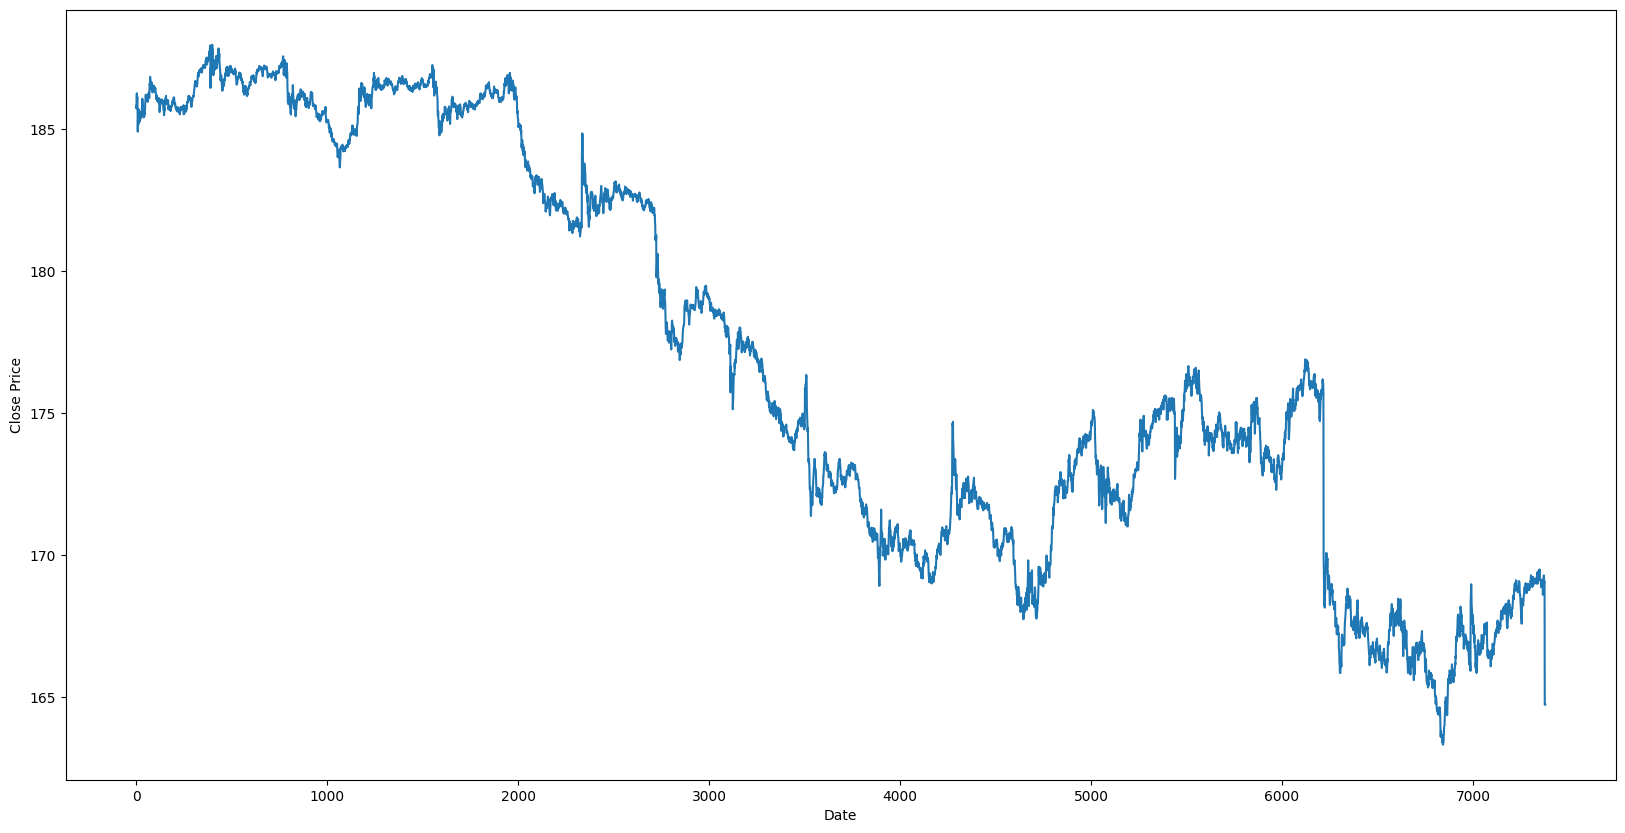

In [ ]:
from yahooquery import Ticker

tickers = Ticker('goog', asynchronous=True)

df = tickers.history(period='1y', interval='1d')
df.head()

import pandas as pd

# plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(df['close'].values)

plt.xlabel('Date')
plt.ylabel('Close Price')